In [1]:
import datetime
import spiceypy
import numpy as np
import pandas as pd

In [2]:
datapath = '/home/einhard/Documents/projects/'
spiceypy.furnsh(datapath + 'zData/spicepy/meta/_kernels.txt')

## Computing SSB WRT Sun

In [3]:
# Loading a 10k day intervals starting on 2000-01-01 UTC and converting to ET
INIT_TIME_UTC = datetime.datetime(year=2000,
                                  month=1,
                                  day=1,
                                  hour=0,
                                  minute=0,
                                  second=0)
DELTA_DAYS = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime('%Y-%m%dT%H:%M:%S')
END_TIME_UTC_STR = END_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')

print(f'Init time in UTC: {INIT_TIME_UTC_STR}')
print(f'End time in UTC: {END_TIME_UTC_STR}')

INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Init time in UTC: 2000-0101T00:00:00
End time in UTC: 2027-05-19T00:00:00


In [4]:
_, RADII_SUN = spiceypy.bodvcd(bodyid=10,
                               item='RADII',
                               maxn=3)
RADIUS_SUN = RADII_SUN[0]

# Starting DF
SOLAR_SYSTEM_DF = pd.DataFrame()

# Set ET column
SOLAR_SYSTEM_DF['ET'] = TIME_INTERVAL_ET

# Returning a column of datetimes
SOLAR_SYSTEM_DF['UTC'] = SOLAR_SYSTEM_DF['ET'].apply(lambda x: spiceypy.et2datetime(et=x).date())


In [5]:
# Calculating SSB WRT Sun
SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'] = SOLAR_SYSTEM_DF['ET'].apply(lambda x: spiceypy.spkgps(targ=0,
                                                                                           et=x,
                                                                                           ref='ECLIPJ2000',
                                                                                           obs=10)[0])

# SSB position vector scaled with Sun radius
SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN_SCALED'] = SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].apply(lambda x: x / RADIUS_SUN)

# Distance between Sun and SSB. Using spiceypy vnorm() is the same as np.linalg.norm()
SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'] = SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN_SCALED'].apply(lambda x: spiceypy.vnorm(x))

In [6]:
SOLAR_SYSTEM_DF

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST
0,8.596864e+06,2000-04-10,"[981298.8099004503, 522823.9012260577, -29247....","[1.409912083190302, 0.7511837661293932, -0.042...",1.598091
1,8.682409e+06,2000-04-10,"[980375.5378942579, 523808.5649520729, -29229....","[1.40858554295152, 0.7525985128621737, -0.0419...",1.597586
2,8.767953e+06,2000-04-11,"[979450.9093421742, 524792.0686642845, -29211....","[1.407257053652549, 0.7540115929084548, -0.041...",1.597081
3,8.853498e+06,2000-04-12,"[978524.921893898, 525774.4071240792, -29193.3...","[1.4059266119165201, 0.7554229987414931, -0.04...",1.596575
4,8.939042e+06,2000-04-13,"[977597.5732511121, 526755.5749608416, -29175....","[1.404594214441253, 0.7568327226448873, -0.041...",1.596069
...,...,...,...,...,...
9995,8.636147e+08,2027-05-15,"[4636.191119371523, 653498.36663582, -10146.92...","[0.006661194137028051, 0.9389344348215805, -0....",0.939071
9996,8.637002e+08,2027-05-16,"[3966.6369441627576, 652892.051996553, -10131....","[0.0056991910117280995, 0.9380632930984957, -0...",0.938194
9997,8.637858e+08,2027-05-17,"[3298.101704120987, 652285.0255147198, -10115....","[0.004738651873737051, 0.9371911286131032, -0....",0.937316
9998,8.638713e+08,2027-05-18,"[2630.5859768933315, 651677.2900300696, -10099...","[0.00377957755300766, 0.9363179454455024, -0.0...",0.936438


## Visualizing

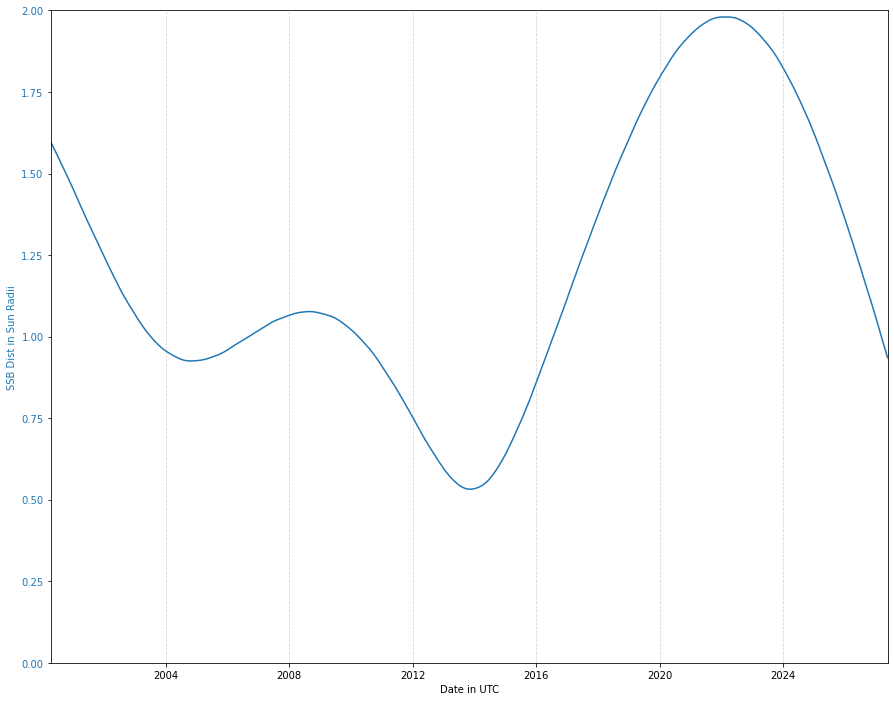

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15,12))

# Plotting distance between Sun and SSB
ax.plot(SOLAR_SYSTEM_DF['UTC'], SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'], color='tab:blue')

# Setting labels and limits
ax.set_xlabel('Date in UTC')
ax.set_ylabel('SSB Dist in Sun Radii', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax.set_xlim(min(SOLAR_SYSTEM_DF['UTC']), max(SOLAR_SYSTEM_DF['UTC']))
ax.set_ylim(0,2)

ax.grid(axis='x', linestyle='dashed', alpha=0.5)

plt.savefig('figures/SSB2SUN_DIST.png', dpi=300)


### Calculating phase angles

In [8]:
# Additionally, we want to compute the position vector of all outer gas
# giants. We define a dictionary with a planet's barycentre abbreviation and
# corresponding NAIF ID code
NAIF_ID_DICT = {'JUP': 5, \
                'SAT': 6, \
                'URA': 7, \
                'NEP': 8}

# Iterate through the dictionary and compute the position vector for each
# planet as seen from the Sun. Further, compute the phase angle between the
# SSB and the planet as seen from the Sun
for planets_name_key in NAIF_ID_DICT:

    # Define the pandas dataframe column for each planet (position and phase
    # angle). Each '%s' substring is replaced with the planets name as
    # indicated after the "%"
    planet_pos_col = 'POS_%s_WRT_SUN' % planets_name_key
    planet_angle_col = 'PHASE_ANGLE_SUN_%s2SSB' % planets_name_key

    # Get the corresponding NAIF ID of the planet's barycentre
    planet_id = NAIF_ID_DICT[planets_name_key]

    # Compute the planet's position as seen from the Sun.
    SOLAR_SYSTEM_DF.loc[:, planet_pos_col] = \
        SOLAR_SYSTEM_DF['ET'].apply(lambda x: \
                                    spiceypy.spkgps(targ=planet_id, \
                                                    et=x, \
                                                    ref='ECLIPJ2000', \
                                                    obs=10)[0])

    # Compute the phase angle between the SSB and the planet as seen from the
    # Sun. Since we apply a lambda function on all columns we need to set
    # axis=1, otherwise we get an error!
    SOLAR_SYSTEM_DF.loc[:, planet_angle_col] = \
        SOLAR_SYSTEM_DF.apply(lambda x: \
                              np.degrees(spiceypy.vsep(x[planet_pos_col], \
                                                       x['POS_SSB_WRT_SUN'])),\
                              axis=1)

In [9]:
SOLAR_SYSTEM_DF

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST,POS_JUP_WRT_SUN,PHASE_ANGLE_SUN_JUP2SSB,POS_SAT_WRT_SUN,PHASE_ANGLE_SUN_SAT2SSB,POS_URA_WRT_SUN,PHASE_ANGLE_SUN_URA2SSB,POS_NEP_WRT_SUN,PHASE_ANGLE_SUN_NEP2SSB
0,8.596864e+06,2000-04-10,"[981298.8099004503, 522823.9012260577, -29247....","[1.409912083190302, 0.7511837661293932, -0.042...",1.598091,"[523705789.14760345, 529894653.75811136, -1392...",17.289462,"[892704866.0807436, 1038850201.1581211, -53576...",21.279712,"[2198430136.890571, -2014469281.845371, -35987...",70.537033,"[2553297165.4763784, -3712070570.3084345, 1760...",83.534754
1,8.682409e+06,2000-04-10,"[980375.5378942579, 523808.5649520729, -29229....","[1.40858554295152, 0.7525985128621737, -0.0419...",1.597586,"[522895135.63082176, 530733188.9843726, -13910...",17.311968,"[892033709.500797, 1039387737.2075577, -535587...",21.248523,"[2198818611.0856986, -2014065983.0856125, -359...",70.593430,"[2553676352.429481, -3711803492.997098, 175896...",83.595999
2,8.767953e+06,2000-04-11,"[979450.9093421742, 524792.0686642845, -29211....","[1.407257053652549, 0.7540115929084548, -0.041...",1.597081,"[522083253.9218779, 531570477.9642626, -138956...",17.334446,"[891362213.8254101, 1039924878.2677865, -53541...",21.217312,"[2199207003.334616, -2013662611.6336315, -3599...",70.649850,"[2554055510.883857, -3711536377.3680716, 17575...",83.657266
3,8.853498e+06,2000-04-12,"[978524.921893898, 525774.4071240792, -29193.3...","[1.4059266119165201, 0.7554229987414931, -0.04...",1.596575,"[521270146.058913, 532406518.8644547, -1388092...",17.356894,"[890690379.2817291, 1040461624.1048598, -53524...",21.186081,"[2199595313.621898, -2013259167.5105581, -3599...",70.706292,"[2554434640.833037, -3711269223.429319, 175612...",83.718556
4,8.939042e+06,2000-04-13,"[977597.5732511121, 526755.5749608416, -29175....","[1.404594214441253, 0.7568327226448873, -0.041...",1.596069,"[520455814.08292466, 533241309.85520214, -1386...",17.379313,"[890018206.0971279, 1040997974.4848423, -53506...",21.154829,"[2199983541.932175, -2012855650.737657, -36001...",70.762757,"[2554813742.270604, -3711002031.1889353, 17547...",83.779868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8.636147e+08,2027-05-15,"[4636.191119371523, 653498.36663582, -10146.92...","[0.006661194137028051, 0.9389344348215805, -0....",0.939071,"[-688407336.9897842, 414818630.4398761, 136791...",59.360868,"[1326943972.2286143, 446141663.9191563, -60590...",70.990124,"[1215388124.5123298, 2635440174.959489, -59704...",24.362384,"[4456603193.847664, 312951557.66304207, -10914...",85.556762
9996,8.637002e+08,2027-05-16,"[3966.6369441627576, 652892.051996553, -10131....","[0.0056991910117280995, 0.9380632930984957, -0...",0.938194,"[-688997014.4518923, 413912216.49146485, 13696...",59.379534,"[1326634943.9410756, 446922554.9428834, -60591...",71.014176,"[1214854147.608802, 2635656377.5846863, -59627...",24.409365,"[4456566944.950261, 313417528.01003784, -10915...",85.609137
9997,8.637858e+08,2027-05-17,"[3298.101704120987, 652285.0255147198, -10115....","[0.004738651873737051, 0.9371911286131032, -0....",0.937316,"[-689585402.7576609, 413005028.0355781, 137130...",59.398173,"[1326325448.1252594, 447703287.48842305, -6059...",71.038246,"[1214320123.3917773, 2635872474.6388273, -5954...",24.456364,"[4456530648.511592, 313883494.23812646, -10916...",85.661531
9998,8.638713e+08,2027-05-18,"[2630.5859768933315, 651677.2900300696, -10099...","[0.00377957755300766, 0.9363179454455024, -0.0...",0.936438,"[-690172500.9903841, 412097066.88119316, 13729...",59.416785,"[1326015484.8472576, 448483861.26802886, -6059...",71.062333,"[1213786051.881762, 2636088466.1132207, -59472...",24.503384,"[4456494304.532532, 314349456.3450614, -109174...",85.713945


In [10]:
# Let's verify the function vsep and compute the phase angle between the SSB
# and Jupiter as seen from the Sun (we use the very first array entries).
# Define a lambda function the computes the angle between two vectors
COMP_ANGLE = lambda vec1, vec2: np.arccos(np.dot(vec1, vec2) \
                                          / (np.linalg.norm(vec1) \
                                             * np.linalg.norm(vec2)))

print('Phase angle between the SSB and Jupiter as seen from the Sun (first ' \
      'array entry, lambda function): %s' % \
      np.degrees(COMP_ANGLE(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0], \
                            SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))


print('Phase angle between the SSB and Jupiter as seen from the Sun (first ' \
      'array entry, SPICE vsep function): %s' % \
      np.degrees(spiceypy.vsep(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0], \
                               SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))

Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, lambda function): 17.28946155228879
Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, SPICE vsep function): 17.28946155228878


## Plotting phase angles

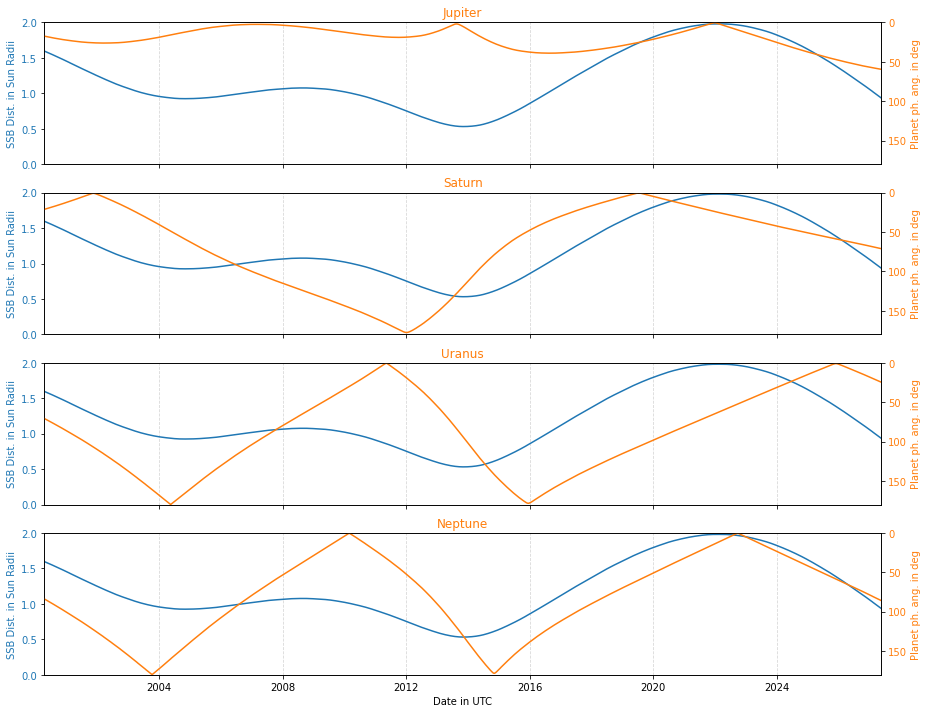

In [11]:
# Creating 4 axes subplot that share the x-axis
fix, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(15,12))

# Iterating through the planets and plotting their phase angles with the SSB, as seen from the Sun

for ax_f, planet_abr, planet_name in zip([ax1, ax2, ax3, ax4],
                                         ['JUP', 'SAT', 'URA', 'NEP'],
                                         ['Jupiter', 'Saturn', 'Uranus', 'Neptune']):
    
    # Set the planet's name as subplot title
    ax_f.set_title(planet_name, color='tab:orange')

    # Plotting distance between SSB and Sun
    ax_f.plot(SOLAR_SYSTEM_DF['UTC'],
              SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'],
              color='tab:blue')
    
    # Setting y label
    ax_f.set_ylabel('SSB Dist. in Sun Radii', color='tab:blue')
    ax_f.tick_params(axis='y', labelcolor='tab:blue')

    # Set xlim based on min-max date, and ylim based on SSB dist
    ax_f.set_xlim(min(SOLAR_SYSTEM_DF['UTC']), max(SOLAR_SYSTEM_DF['UTC']))
    ax_f.set_ylim(0, 2)

    # Adding phase angle values
    ax_f_add = ax_f.twinx()

    # Plotting phase angles
    ax_f_add.plot(SOLAR_SYSTEM_DF['UTC'],
                  SOLAR_SYSTEM_DF[f'PHASE_ANGLE_SUN_{planet_abr}2SSB'],
                  color='tab:orange', linestyle='-')
    
    # Setting y label name and color
    ax_f_add.set_ylabel('Planet ph. ang. in deg', color='tab:orange')
    ax_f_add.tick_params(axis='y', labelcolor='tab:orange')

    # Inverting y axis.  This is done so that anti-correlation becomes more obvious (that is,     a large phase angle corresponds to a smaller distance between the Sun's center and SSB)
    ax_f_add.invert_yaxis()
    ax_f_add.set_ylim(180, 0)

    # Setting a grid
    ax_f.grid(axis='x', linestyle='dashed', alpha=0.5)

# Setting x label
ax4.set_xlabel('Date in UTC')

fig.tight_layout()

# reducing distance between axes
plt.subplots_adjust(hspace=0.2)

plt.savefig('figures/PLANETS_SUN_SSB_PHASE_ANGLE.png', dpi=300)
